In [1]:
import platform
platform.python_version()

'3.11.14'

In [2]:
import os,csv,re
import pandas as pd
import numpy as np

import math
from scipy.sparse import issparse
import random 
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

import time

In [3]:
seeds = [0]
random.seed(seeds[0])
np.random.seed(seeds[0])

In [4]:
print(f" numpy: {np.__version__}, pandas: {pd.__version__} scanpy: {sc.__version__}")

def print_adata_minmax(adata):
    print(f"minimum value: {np.amax(adata.X):0.3f}, maximum value: {np.amin(adata.X):0.3f}\n")

 numpy: 2.3.4, pandas: 2.3.3 scanpy: 1.11.5


In [5]:
from sklearn.metrics.cluster import adjusted_rand_score

def calc_ari(adata, manual:str, predicted:str):
    return adjusted_rand_score(
        adata.obs[manual].cat.codes, 
        adata.obs[predicted].cat.codes
    )

In [6]:
from scanpy import read_10x_h5

samples = [
    "151507","151669","151673"
]

num_clusters_list = [7,5,7]

samples_data = {}

## Pre-process data

In [ ]:
from banksy_utils import filter_utils
from banksy.embed_banksy import convert2dense
    
def load_multisamples_as_one(sample):
    ### data loading ###
    data_path = os.path.join("data","DLPFC", sample)
    expr_path = os.path.join(data_path, f"{sample}_raw_feature_bc_matrix.h5")
    spatial_path = os.path.join(data_path, f"tissue_positions_list.txt")
    manual_path = os.path.join("data","DLPFC","barcode_level_layer_map.tsv")

    # load data
    adata = read_10x_h5(expr_path)
    spatial = pd.read_csv(spatial_path, sep=",", header=None,
                          na_filter=False, index_col=0)
    spatial = pd.merge(adata.obs, spatial, how='left', left_index=True, right_index=True) #match order in adata object

    # load manual annotations
    manual = pd.read_csv(manual_path, sep="\t", header=None,
                         names=["sample_no", "layer"],
                         na_filter=False, index_col=0)
    manual = manual.loc[manual["sample_no"] == int(sample), :]
    manual = pd.merge(adata.obs, manual, how='left', left_index=True, right_index=True) #match order in adata object

    adata.var_names_make_unique(join = ".")

    # include coordinates information
    adata.obs["x1"] = spatial[1]
    adata.obs["x_array"] = spatial[2]
    adata.obs["y_array"] = spatial[3]
    adata.obs["x_pixel"] = spatial[4]
    adata.obs["y_pixel"] = spatial[5]

    # include manual annotation
    adata.obs["manual_annotations"] = manual["layer"]
    adata.obs["manual_annotations"].fillna(value="other", inplace=True)

    adata.obs["manual_annotations"] = adata.obs["manual_annotations"].astype("category")

    # Select captured samples
    adata.var_names = [i.upper() for i in list(adata.var_names)]
    adata.var["genename"] = adata.var.index.astype("str")
    return adata


## Load sample
Load multiple samples into a ***single AnnData*** object.<br>
Note: Assume common genes across all samples

In [ ]:
for sample in samples:
    if sample == samples[0]:
        adata = load_multisamples_as_one(sample)
        adata.obs['sample'] = sample
        print('*'*10 + str(sample) + '*'*10)
        print(adata)
    else:
        adata_temp = load_multisamples_as_one(sample)
        adata_temp.obs['sample'] = sample
        adata_temp_obs = pd.concat([adata.obs, adata_temp.obs])
        adata = ad.concat([adata, adata_temp], label="sample",  join="outer")
        adata.obs = adata_temp_obs
        print('*'*10 + str(sample) + '*'*10)
        print(adata)

# remove unannotated spots
adata = adata[adata.obs["manual_annotations"] != "other", :]

tar_sum = np.median(adata.X.sum(axis=1).A1)


**********151507**********
AnnData object with n_obs × n_vars = 4992 × 33538
    obs: 'x1', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'manual_annotations', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
**********151669**********
AnnData object with n_obs × n_vars = 9984 × 33538
    obs: 'x1', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'manual_annotations', 'sample'
**********151673**********
AnnData object with n_obs × n_vars = 14976 × 33538
    obs: 'x1', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'manual_annotations', 'sample'


## Stagger the spatial coordinates across the samples, so that spots from different samples do not overlap (sample specific treatment)

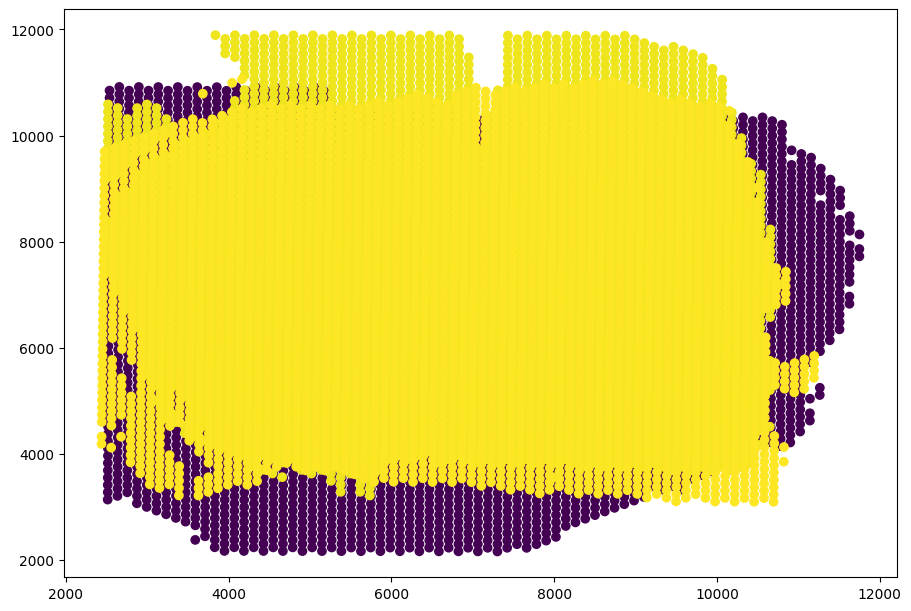

In [ ]:
# Before staggering the spatial coordinates
fig  = plt.figure(figsize=(9, 6) , constrained_layout=True)
scatterplot = plt.scatter(adata.obs['x_pixel'],
                          adata.obs['y_pixel'],
                          c=[int(x) for x in adata.obs['sample']])

In [ ]:
# Staggering
coords_df = pd.DataFrame(adata.obs[['x_pixel', 'y_pixel', 'sample']])
coords_df['x_pixel'] = coords_df.groupby('sample')['x_pixel'].transform(lambda x: x - x.min())
global_max_x = max(coords_df['x_pixel']) * 1.5

In [ ]:
#Turn samples into factors
coords_df['sample_no'] = pd.Categorical(coords_df['sample']).codes

#Update x coordinates
coords_df['x_pixel'] = coords_df['x_pixel'] + coords_df['sample_no'] * global_max_x
coords_df

x_pixel  y_pixel  sample  sample_no
AAACAACGAATAGTTC-1      1.0     3276  151507          0
AAACAAGTATCTCCCA-1   6007.0     9178  151507          0
AAACAATCTACTAGCA-1    365.0     5133  151507          0
AAACACCAATAACTGC-1   7068.0     3462  151507          0
AAACAGCTTTCAGAAG-1   5150.0     2779  151507          0
...                     ...      ...     ...        ...
TTGTTTCACATCCAGG-1  34673.0     5653  151673          2
TTGTTTCATTAGTCTA-1  34907.0     4825  151673          2
TTGTTTCCATACAACT-1  33108.0     4631  151673          2
TTGTTTGTATTACACG-1  36470.0     5571  151673          2
TTGTTTGTGTAAATTC-1  28568.0     6317  151673          2

[11468 rows x 4 columns]

In [ ]:
#Update staggered coords to AnnData object
adata.obs['x_pixel'] = coords_df['x_pixel']
adata.obs['y_pixel'] = coords_df['y_pixel']

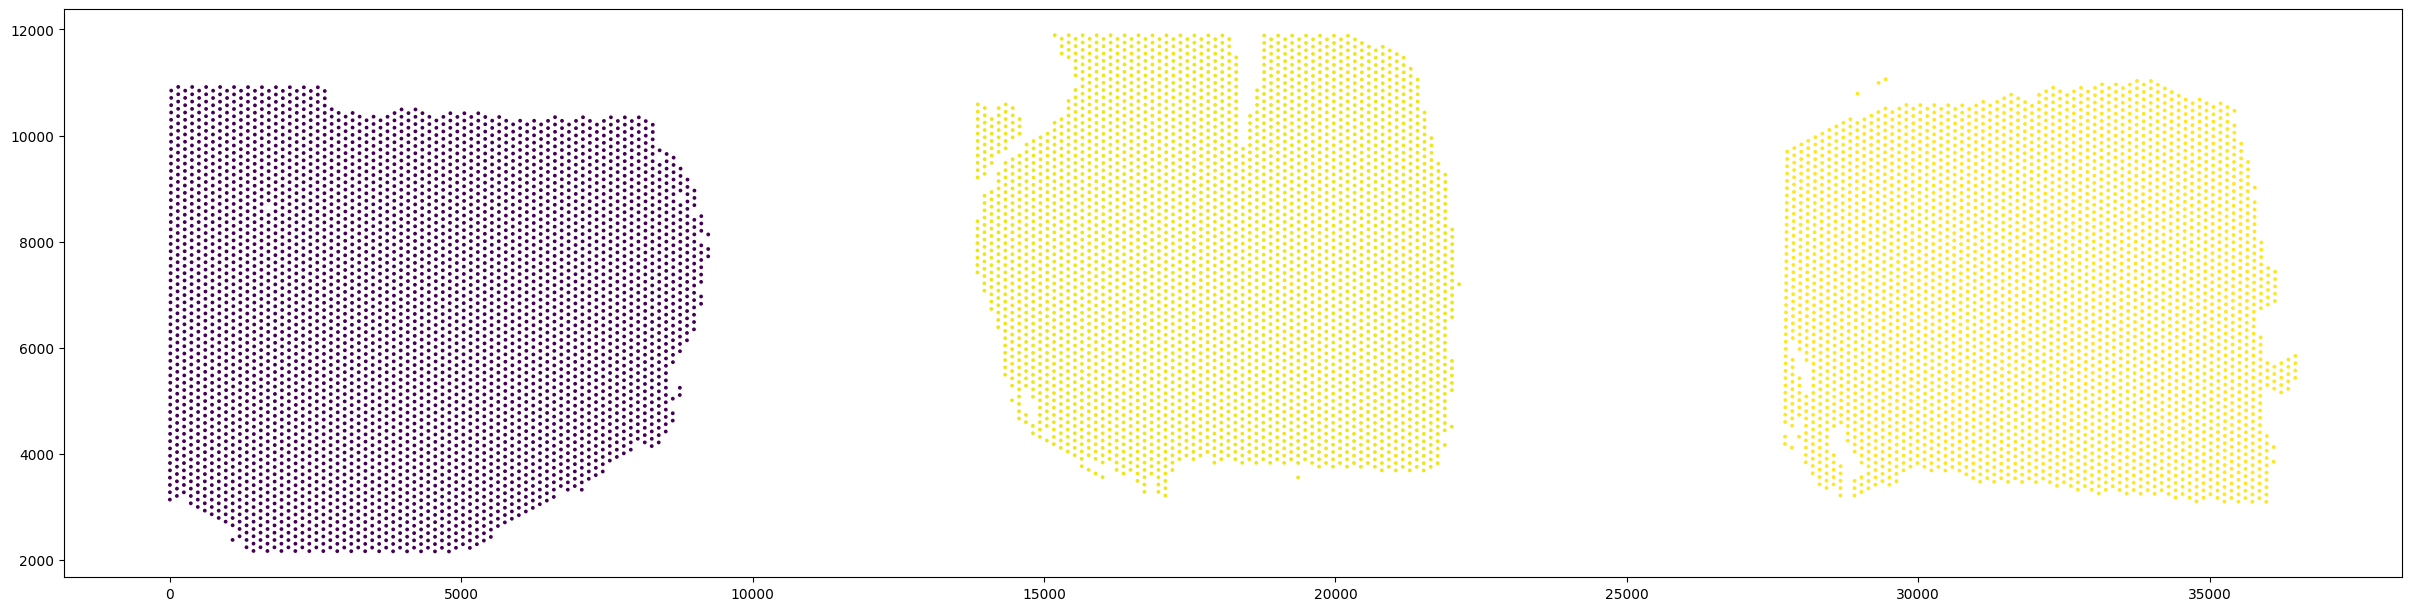

In [ ]:
# AFTER staggering the spatial coordinates
fig  = plt.figure(figsize=(24, 6) , constrained_layout=True)
scatterplot = plt.scatter(adata.obs['x_pixel'],
                          adata.obs['y_pixel'],
                          c=[int(x) for x in adata.obs['sample']],
                          s=3)

# Data Preprocessing

In [ ]:
# normalization
adata = filter_utils.normalize_total(adata,) 
# adata = filter_utils.normalize_total(adata, method = 'RC', target_sum=tar_sum) 

--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 610.0, Min: 0.0



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 260.3711242675781, Min: 0.0



### Subset to 2000 HVGs
R derived HVGs are used to match results in Banksy R vignette 

In [ ]:
r_hvg = pd.read_csv(os.path.join("data","DLPFC", "harmony", "Rvig_harmony2k.csv")) #HVGs Union of all 4 samples 
r_hvg
r_hvg['hvgs'] = r_hvg['hvgs'].str.upper()
r_hvg = r_hvg.astype(str)
adata = adata[:, r_hvg['hvgs']]

## Running BANKSY (with AGF)
Finally we run BANKSY using the following (default) parameters for `cell-typing`:
- $k_{geom} = 18 $
-  $\lambda = 0.2$
- m = 1 (first order azimuthal transform)
</br>

From, the BANKSY embeddings, we then
- Run PCA with 20 PCs
- Perform Leiden clustering with a suitable resolution parameter
<br>

### Calculate Banksy matrix


Median distance to closest cell = 137.00364958642524

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----

---- Ran generate_spatial_distance_graph in 0.03 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.15 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 239.00209204105306, mode = 137.0

---- Ran plot_edge_histogram in 0.02 s ----


Edge weights (weights between cells): median = 0.04552700786375099, mode = 0.03221031888567965

---- Ran plot_edge_histogram in 0.02 s ----

---- Ran generate_spatial_distance_graph in 0.05 s ----

---- Ran theta_from_spatial_graph in 0.05 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.22 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 364.00137362378183, mode = 360.26376387869516

---- Ran plot_edge_histogram in 0.02 s ----


Edge weights (w

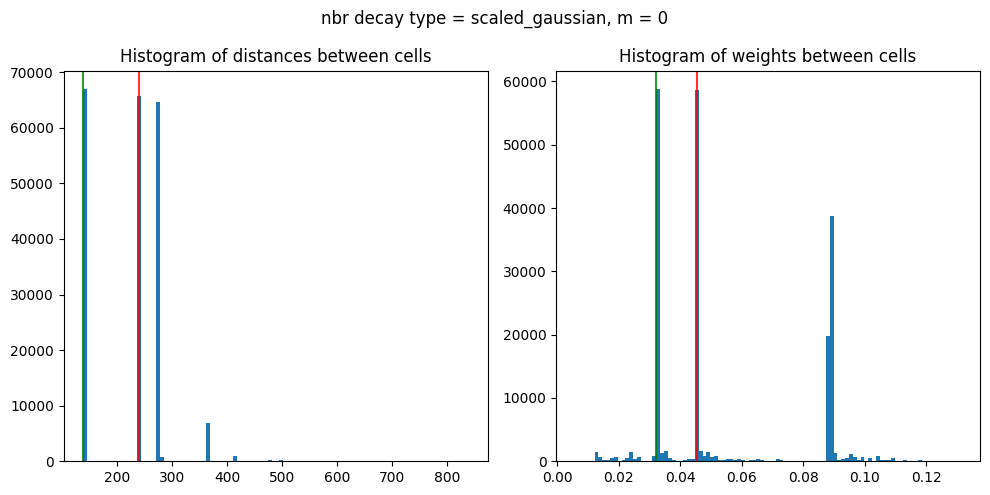

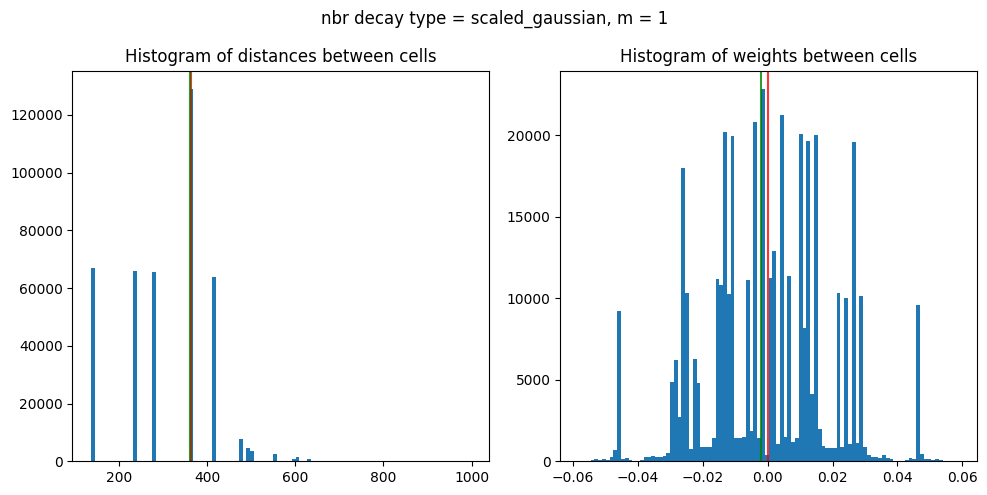

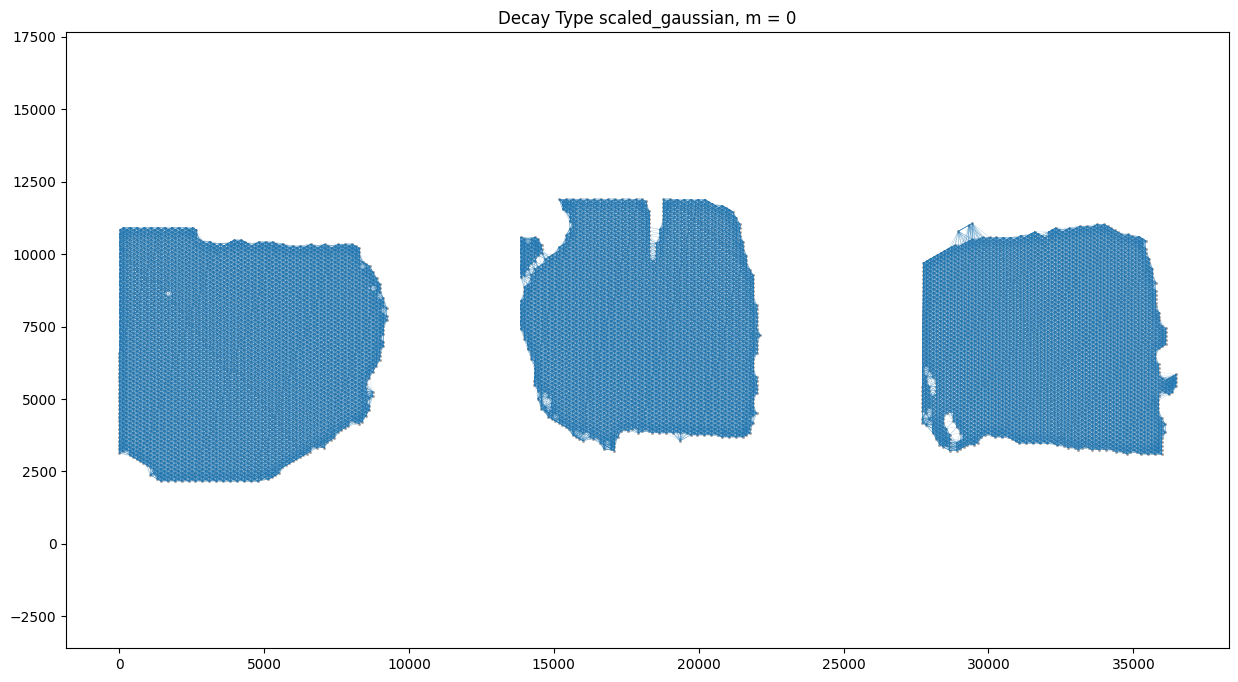

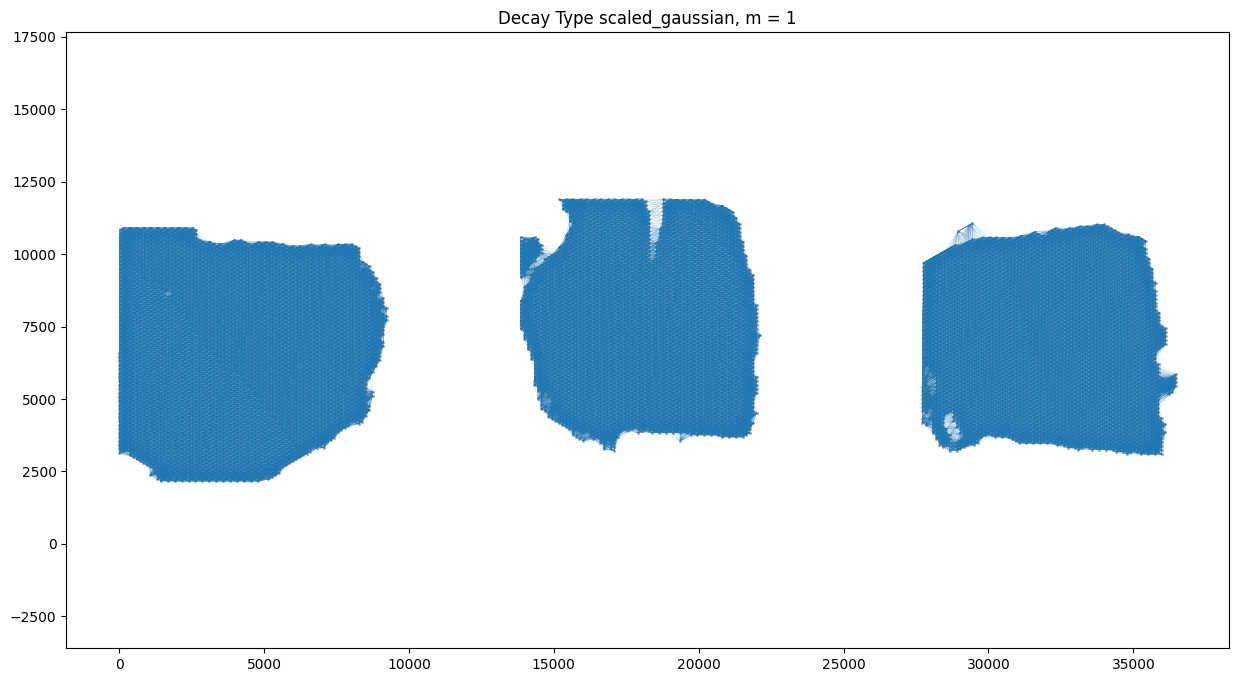

In [ ]:
## banksy parameters ##
from banksy.initialize_banksy import initialize_banksy
coord_keys = ('x_pixel', 'y_pixel', 'coord_xy')
nbr_weight_decay = 'scaled_gaussian'
k_geom = 18
x_coord, y_coord, xy_coord = coord_keys[0], coord_keys[1], coord_keys[2]


from banksy.main import concatenate_all
from banksy.embed_banksy import generate_banksy_matrix
resolutions = [0.40] # clustering resolution for UMAP
pca_dims = [20] # Dimensionality in which PCA reduces to
lambda_list = [0.2] # list of lambda parameters
m = 1
from banksy_utils.umap_pca import pca_umap
from banksy.cluster_methods import run_Leiden_partition
from banksy.plot_banksy import plot_results
c_map =  'tab20' # specify color map


### run banksy ###


# Include spatial coordinates information
raw_y, raw_x = adata.obs[y_coord], adata.obs[x_coord]
adata.obsm[xy_coord] = np.vstack((adata.obs[x_coord].values, adata.obs[y_coord].values)).T

banksy_dict = initialize_banksy(adata,
                                coord_keys,
                                k_geom,
                                nbr_weight_decay=nbr_weight_decay,
                                max_m=m,
                                plt_edge_hist= True,
                                plt_nbr_weights= True,
                                plt_agf_angles=False,
                                plt_theta=False
                               )

banksy_dict, banksy_matrix = generate_banksy_matrix(adata,
                                                    banksy_dict,
                                                    lambda_list,
                                                    max_m=m)


banksy_dict["nonspatial"] = {
    # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
    0.0: {"adata": concatenate_all([adata.X], 0, adata=adata), }
}

print(banksy_dict['nonspatial'][0.0]['adata'])

## Dimensionality Reduction and Harmony 

1. Generate PCA embeddings
2. Integrate PCA embeddings across different samples using Harmony

Current decay types: ['scaled_gaussian', 'nonspatial']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.2)

Setting the total number of PC = 20
Original shape of matrix: (11468, 6000)
Reduced shape of matrix: (11468, 20)
------------------------------------------------------------
min_value = -35.18703174928263, mean = -8.5403915850342005e-16, max = 164.94759972765135


Reducing dims of dataset in (Index = nonspatial, lambda = 0.0)

Setting the total number of PC = 20
Original shape of matrix: (11468, 2000)
Reduced shape of matrix: (11468, 20)
------------------------------------------------------------
min_value = -48.52951166296739, mean = -3.110328334073686e-17, max = 163.57322401019175



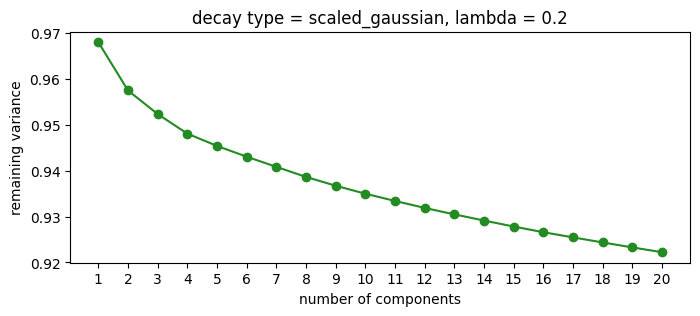

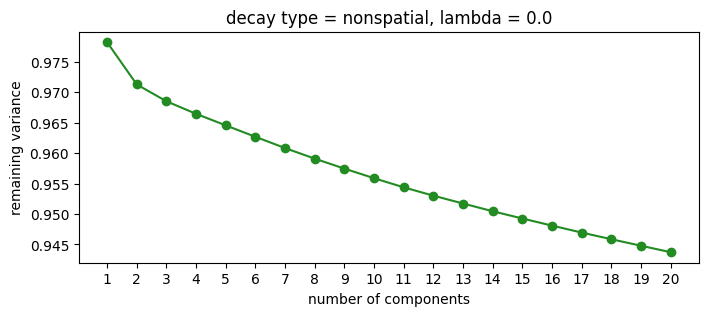

In [ ]:
pca_umap(banksy_dict,
         pca_dims=pca_dims,
         add_umap=False
        )

In [ ]:
from harmony import harmonize
import umap

for pca_dim in pca_dims:
    # Run Harmony on PCA
    Z = harmonize(banksy_dict[nbr_weight_decay][0.2]["adata"].obsm[f'reduced_pc_{pca_dim}'], 
                  banksy_dict[nbr_weight_decay][0.2]["adata"].obs, batch_key = 'sample')
    
    print(f'Replacing adata.obsm["reduced_pc_{pca_dim}"] with harmony corrected embeddings.')
    banksy_dict[nbr_weight_decay][0.2]["adata"].obsm[f'reduced_pc_{pca_dim}'] = Z
    
    # Run UMAP
    reducer = umap.UMAP(transform_seed = 42)
    umap_embedding = reducer.fit_transform(Z)
    banksy_dict[nbr_weight_decay][0.2]["adata"].obsm[f"reduced_pc_{pca_dim}_umap"] = umap_embedding

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).
Replacing adata.obsm["reduced_pc_20"] with harmony corrected embeddings.


## Run Banksy Clustering

In [ ]:
from banksy.cluster_methods import run_Leiden_partition

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50,
    num_iterations = -1,
    partition_seed = 1234,
    match_labels = True,
)

Decay type: scaled_gaussian
Neighbourhood Contribution (Lambda Parameter): 0.2
reduced_pc_20 

reduced_pc_20_umap 

PCA dims to analyse: [20]

Setting up partitioner for (nbr decay = scaled_gaussian), Neighbourhood contribution = 0.2, PCA dimensions = 20)


Nearest-neighbour weighted graph (dtype: float64, shape: (11468, 11468)) has 573400 nonzero entries.
---- Ran find_nn in 1.49 s ----


Nearest-neighbour connectivity graph (dtype: int16, shape: (11468, 11468)) has 573400 nonzero entries.

(after computing shared NN)
Allowing nearest neighbours only reduced the number of shared NN from 9133448 to 572722.


Shared nearest-neighbour (connections only) graph (dtype: int16, shape: (11468, 11468)) has 554159 nonzero entries.

Shared nearest-neighbour (number of shared neighbours as weights) graph (dtype: int16, shape: (11468, 11468)) has 554159 nonzero entries.

sNN graph data:
[32 21 26 ... 12 14 14]

---- Ran shared_nn in 0.33 s ----


-- Multiplying sNN connectivity by weights --


sha

decay  lambda_param  num_pcs  \
nonspatial_pc20_nc0.00_r0.40            nonspatial           0.0       20   
scaled_gaussian_pc20_nc0.20_r0.40  scaled_gaussian           0.2       20   

                                   resolution  num_labels  \
nonspatial_pc20_nc0.00_r0.40              0.4           6   
scaled_gaussian_pc20_nc0.20_r0.40         0.4           7   

                                                                              labels  \
nonspatial_pc20_nc0.00_r0.40       Label object:\nNumber of labels: 6, number of ...   
scaled_gaussian_pc20_nc0.20_r0.40  Label object:\nNumber of labels: 7, number of ...   

                                                                               adata  \
nonspatial_pc20_nc0.00_r0.40       [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.20_r0.40  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
nonspatial_pc20_nc0.00_r0.40       Label object:\nNumber of labels: 6, number of ...  
scaled_gaussian_pc20_nc0.20_r0.40  Label object:\nNumber of labels: 7, number of ...

## Plot Banksy clustering result

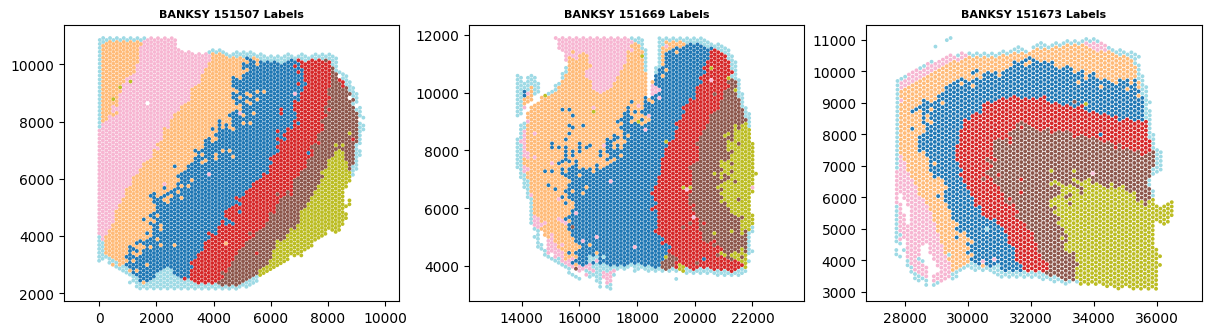

In [ ]:
fig  = plt.figure(figsize=(12, 6) , constrained_layout=True)
grid = fig.add_gridspec(ncols=3, nrows=2) #modify columns and row of final plot base on expected output figure 

for counter, sample in enumerate(samples):
    for params_name in results_df.index:
        if params_name == 'scaled_gaussian_pc20_nc0.20_r0.40': 
            tmp_df = results_df
            tmp_label = tmp_df.loc[params_name, "labels"]
            tmp_adata = tmp_df.loc[params_name, "adata"].copy()

            # If label information is not stored in anndata object 
            tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)
        
            adata_plt_temp = tmp_adata[tmp_adata.obs['sample'] == sample]
            
            # plot refined spatial plot
            ax_locs1 = fig.add_subplot(grid[0, counter])
            scatterplot = ax_locs1.scatter(adata_plt_temp.obs[coord_keys[0]],
                                          adata_plt_temp.obs[coord_keys[1]],
                                          c=adata_plt_temp.obs['labels_' + params_name],
                                          cmap=c_map,
                                          vmin=0, vmax=max_num_labels - 1,
                                          s=3, alpha=1.0)
            ax_locs1.set_aspect('equal', 'datalim')
            ax_locs1.set_title(f'BANKSY {sample} Labels', fontsize=8, fontweight="bold", )

## Compute ARI

In [ ]:
ari = []
num_clus = []
sample_series = []
index_series = []

for counter, sample in enumerate(samples):
    for params_name in results_df.index:
        tmp_df = results_df
        tmp_label = tmp_df.loc[params_name, "labels"]
        tmp_adata = tmp_df.loc[params_name, "adata"].copy()

        
        # If label information is not stored in anndata object 
        tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)
        
        adata_ari_temp = tmp_adata[tmp_adata.obs['sample'] == sample]
        adata_ari_temp.obs["manual_annotations"] = adata_ari_temp.obs["manual_annotations"].astype("category") # convert to categorical data for ARI computation

        ari.append(calc_ari(adata_ari_temp, "manual_annotations", 'labels_' + params_name))
        num_clus.append(results_df.loc[params_name, "num_labels"])
        sample_series.append(sample)
        index_series.append(params_name)

ari_df = pd.DataFrame(ari)
ari_df['num_labels'] = num_clus
ari_df['sample'] = sample_series
ari_df['df_index'] = index_series

### Identify banksy output matching target num_labels

In [ ]:
for i, sample in enumerate(samples):
    tar_clus = num_clusters_list[i]
    print(ari_df[(ari_df['num_labels']==tar_clus) & (ari_df['sample'] == sample) & (ari_df['df_index'].str.contains('scaled_gaussian_'))])
    print(np.median(ari_df[0][(ari_df['num_labels']==tar_clus) & (ari_df['sample'] == sample) & (ari_df['df_index'].str.contains('scaled_gaussian_'))]))

          0  num_labels  sample                           df_index
1  0.504344           7  151507  scaled_gaussian_pc20_nc0.20_r0.40
0.5043436892342855
Empty DataFrame
Columns: [0, num_labels, sample, df_index]
Index: []
nan
        0  num_labels  sample                           df_index
5  0.5892           7  151673  scaled_gaussian_pc20_nc0.20_r0.40
0.5891996255382385


### Plot banksy results

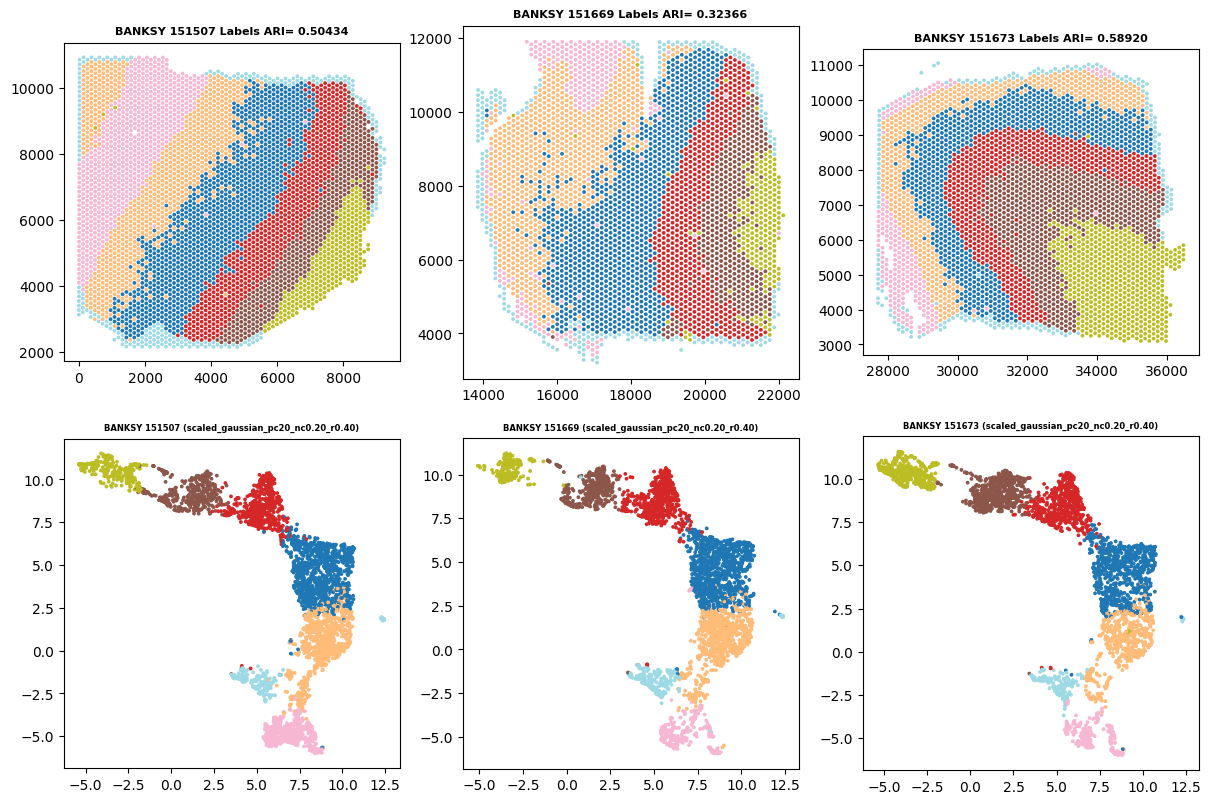

In [ ]:
target_params = ['scaled_gaussian_pc20_nc0.20_r0.40' ]

fig  = plt.figure(figsize=(12,8), constrained_layout=True)
grid = fig.add_gridspec(ncols=3, nrows=2)

for counter, sample in enumerate(samples):
    for counter2, params_name in enumerate(target_params):
        tmp_df = results_df
        tmp_label = tmp_df.loc[params_name, "labels"]
        tmp_adata = tmp_df.loc[params_name, "adata"].copy()

        
        # If label information is not stored in anndata object 
        tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)
        
        adata_ari_temp = tmp_adata[tmp_adata.obs['sample'] == sample]
        print_ari = ari_df[(ari_df['sample'] == sample) & (ari_df['df_index'].str.contains(params_name))][0].values[0]
       
        ## plot spatial location
        ax_locs1 = fig.add_subplot(grid[counter2*2, counter])
        weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]
        scatterplot = ax_locs1.scatter(adata_ari_temp.obs[coord_keys[0]],
                                       adata_ari_temp.obs[coord_keys[1]],
                                       c=adata_ari_temp.obs['labels_' + params_name],
                                       cmap=c_map,
                                       vmin=0, vmax=max_num_labels - 1,
                                       s=3, alpha=1.0)
        ax_locs1.set_aspect('equal')
        ax_locs1.set_title(f'BANKSY {sample} Labels ARI= {print_ari:.5f}', fontsize=8, fontweight="bold", )
        
        # plot  UMAP
        ax_locs2 = fig.add_subplot(grid[1+counter2*2, counter])
        scatterplot = ax_locs2.scatter(adata_ari_temp.obsm['reduced_pc_20_umap'][:,0],
                                       adata_ari_temp.obsm['reduced_pc_20_umap'][:,1],
                                       c=adata_ari_temp.obs['labels_' + params_name],
                                       cmap=c_map,
                                       s=3, alpha=1.0)
        ax_locs2.set_aspect('equal')
        ax_locs2.set_title(f'BANKSY {sample} ({params_name})', fontsize=6, fontweight="bold", )

### Refined banksy labels


Number of nodes swapped 306 | ratio: 0.072
Total Entropy: 0.31

Number of nodes swapped 325 | ratio: 0.089
Total Entropy: 0.41

Number of nodes swapped 299 | ratio: 0.083
Total Entropy: 0.35


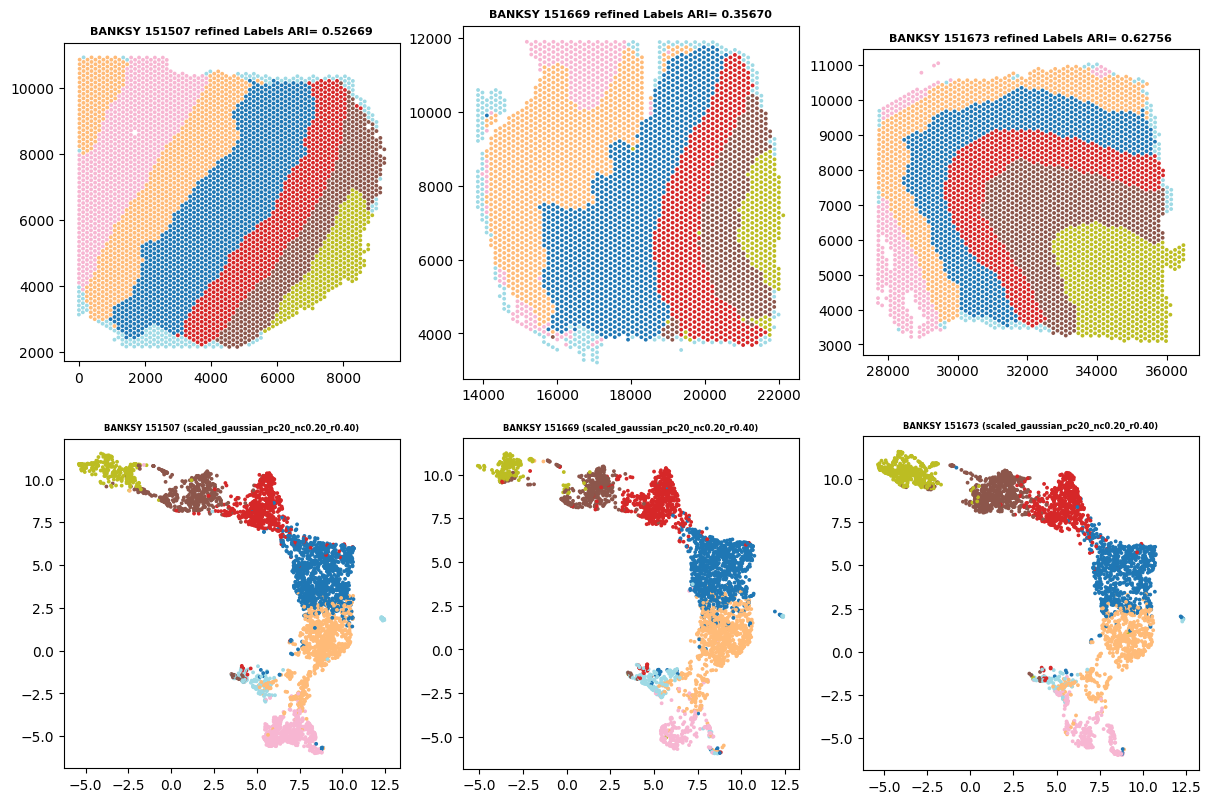

In [ ]:
from banksy_utils.refine_clusters import refine_once

target_params = ['scaled_gaussian_pc20_nc0.20_r0.40' ]

fig  = plt.figure(figsize=(12,8) , constrained_layout=True)
grid = fig.add_gridspec(ncols=3, nrows=2)

for counter, sample in enumerate(samples):
    for counter2, params_name in enumerate(target_params):
        tmp_df = results_df
        tmp_label = tmp_df.loc[params_name, "labels"]
        tmp_adata = tmp_df.loc[params_name, "adata"].copy()

        # If label information is not stored in anndata object
        tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)

        adata_ari_temp = tmp_adata[tmp_adata.obs['sample'] == sample]
        adata_ari_temp.obs["manual_annotations"] = adata_ari_temp.obs["manual_annotations"].astype("category") # convert to categorical data for ARI computation


        ### refine labeling results
        adata_ari_temp.obsm['coord_xy'] = adata.obsm['coord_xy'][adata.obs['sample']==sample]
        refine_label, refine_ari, total_entropy = refine_once(adata_ari_temp,
                                      raw_labels = adata_ari_temp.obs['labels_' + params_name],
                                      truth_labels = adata_ari_temp.obs['manual_annotations'].values,
                                      coord_keys = coord_keys,
                                      num_neigh = k_geom)

        # plot refined spatial plot
        ax_locs1 = fig.add_subplot(grid[counter2*2, counter])
        scatterplot = ax_locs1.scatter(adata_ari_temp.obs[coord_keys[0]],
                                      adata_ari_temp.obs[coord_keys[1]],
                                      c=refine_label,
                                      cmap=c_map,
                                      vmin=0, vmax=max_num_labels - 1,
                                      s=3, alpha=1.0)
        ax_locs1.set_aspect('equal')
        ax_locs1.set_title(f'BANKSY {sample} refined Labels ARI= {refine_ari:.5f}', fontsize=8, fontweight="bold", )
        
        # plot refined UMAP
        ax_locs2 = fig.add_subplot(grid[1+counter2*2, counter])
        scatterplot = ax_locs2.scatter(adata_ari_temp.obsm['reduced_pc_20_umap'][:,0],
                                       adata_ari_temp.obsm['reduced_pc_20_umap'][:,1],
                                       c=refine_label,
                                       cmap=c_map,
                                       s=3, alpha=1.0)
        ax_locs2.set_aspect('equal')
        ax_locs2.set_title(f'BANKSY {sample} ({params_name})', fontsize=6, fontweight="bold", )